# 3. Frame Selection Process

In [1]:
from src import *

In [2]:
import pygmo as pg

## Description

We look in this section for the stability of frame selected gradients across subjects (individual gradients approach) and also how stable the group gradients are when frame selecting compared to when full is used. 

GOAL: Evaluate differences of individual gradients of selected gradients and movie long gradients + evaluate differences of group gradients of selected timeseries and group gradients of full movies 

## Table of Contents
- [Frame selected (by discrete emotion timecourses) series](#discreteemo)
- [Frame selected (by 3FA timecourses) series](#3fa)
- [Frame selected (by combination 3FA timecourses) series](#comb3fa)
- [Frame selected (by pareto 3FA timecourses) series](#pareto3fa)

In [3]:
def compute_mask_percentile(series, lb, rb):
    """
        Compute Mask for a 1d series (mostly) with left bound (lb)
        and right bound (rb) in percentile format
        
        
        lb::[int] percentile
        rb::[int] percentile
    """
    
    eval_lb = np.percentile(series, lb)
    eval_rb = np.percentile(series, rb)
    ret = (series >= eval_lb) & (series <= eval_rb)
    return ret


def find_boundcontinuous(m):
    """
        Return pairs of bounds corresponding to the 
        percentiles of the timecourse value we want
        
        m::[1darray] timecourse
    """
    
    P = []
    cur_start = 0
    prev_val = m[0]
    for k in range(1,len(m)):
        cur_val = m[k]
        if prev_val and cur_val:
            continue
        if prev_val and (not cur_val):
            P.append((cur_start,k-1))
            cur_start = k
        if (not prev_val) and cur_val:
            cur_start = k

        prev_val = cur_val
    
    if cur_val and cur_start != k:
        P.append((cur_start, k))
    return P

<a class="anchor" id="discreteemo"></a>
## Frame selected (by discrete emotion timecourses) series

#### Defining Emotion Intensity

In [15]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

tmpdf = pd.read_csv('./data/emotion_compileBIDS.csv')

In [16]:
# Compute intensity metrics:
tmp_series = {}
for moviename in tmpdf.filename.unique():
    tmp_series[moviename] = []
    cur_series = tmpdf[tmpdf.filename==moviename]
    for idx,s in enumerate(select):
        distrib = list(cur_series[cur_series.item == s]['score'])
        if len(distrib) == 0: continue
        tmp_series[moviename].append(distrib)

# 1. Sum squares combining all emotions for each movie
intensity1_series = {}
for moviename in tmpdf.filename.unique():
    intensity1_series[moviename[2:-6]] = (np.asarray(tmp_series[moviename]) ** 2).sum(axis=0)
    
# 2. Averaging groups of emotions [detailed below] then sum squares combining
groups = [["Guilt", "Anger", "Disgust"], ["Sad"], ["Anxiety", "Fear", "Surprise"], ["Satisfaction", "Happiness", "Pride"], ["Love", "WarmHeartedness", "Regard"]]
groups_idx = np.asarray([[1, 0, 3], [12], [7, 5, 10], [8, 4, 9], [11, 2, 6]])
intensity2_series = {}
for moviename in tmpdf.filename.unique():
    tmp2_series = []
    # averaging per group (intermatiate mapping)
    for gidx in groups_idx:
        tmp2_series.append(np.asarray(tmp_series[moviename])[gidx].mean(axis=0))
    intensity2_series[moviename[2:-6]] = (np.asarray(tmp2_series) ** 2).sum(axis=0)

# 3. Group negative emotions then direct sum
groups = [["Guilt", "Anger", "Disgust", "Sad", "Anxiety", "Fear", "Surprise"], ["Satisfaction", "Happiness", "Pride", "Love", "WarmHeartedness", "Regard"]]
groups_idx = np.asarray([[1], [0], [3], [12], [7], [5], [10]])
intensity3_series = {}
for moviename in tmpdf.filename.unique():
    tmp2_series = []
    # averaging per group (intermatiate mapping)
    for gidx in groups_idx:
        tmp2_series.append(np.asarray(tmp_series[moviename])[gidx].mean(axis=0))
    intensity3_series[moviename[2:-6]] = np.asarray(tmp2_series).sum(axis=0)
    
# 4. Group positive emotions then direct sum 
groups = ["Satisfaction", "Happiness", "Pride", "Love", "WarmHeartedness", "Regard"]
groups_idx = np.asarray([[8], [4], [9], [11], [2], [6]])
intensity4_series = {}
for moviename in tmpdf.filename.unique():
    tmp2_series = []
    # averaging per group (intermatiate mapping)
    for gidx in groups_idx:
        tmp2_series.append(np.asarray(tmp_series[moviename])[gidx].mean(axis=0))
    intensity4_series[moviename[2:-6]] = np.asarray(tmp2_series).sum(axis=0)

/tmp/ipykernel_57845/68077505.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups_idx = np.asarray([[1, 0, 3], [12], [7, 5, 10], [8, 4, 9], [11, 2, 6]])


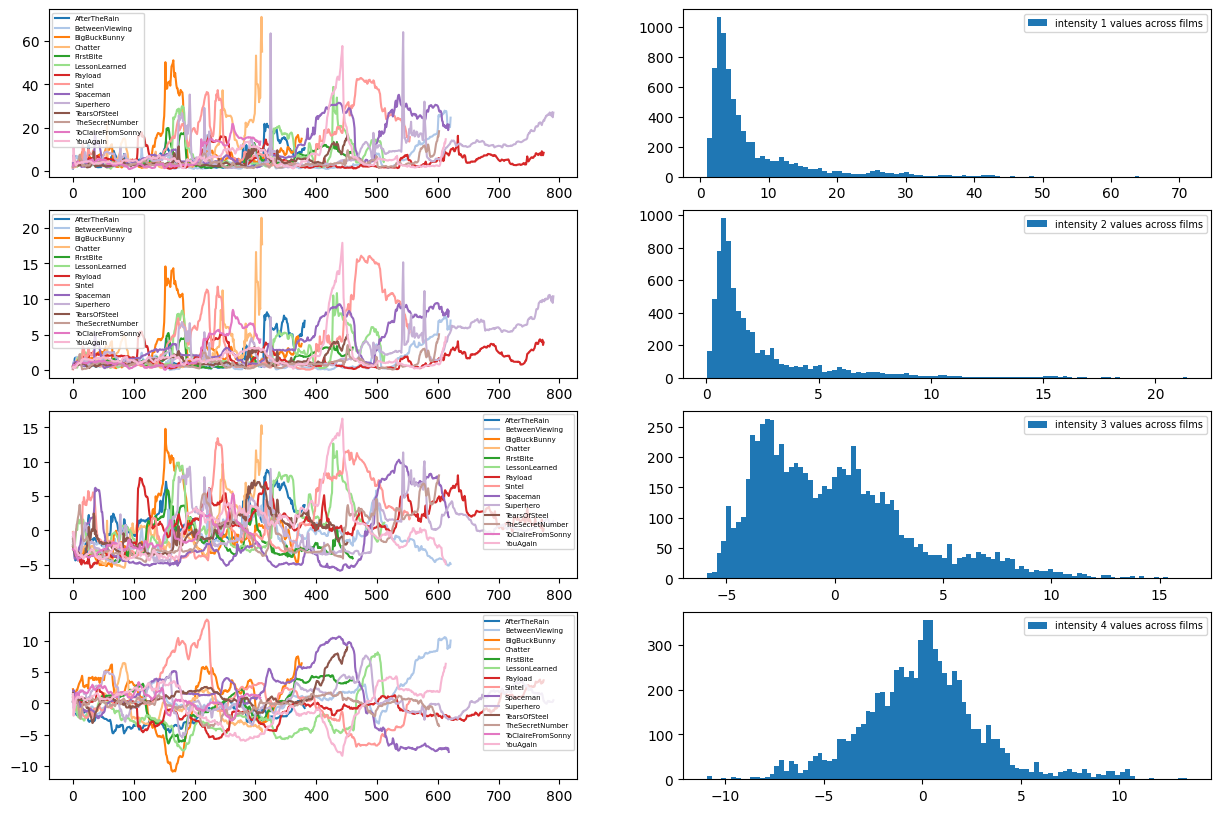

In [17]:
from matplotlib.colors import ListedColormap
intensity_scores = [intensity1_series, intensity2_series, intensity3_series, intensity4_series]
# Displaying
pal     = sns.color_palette('tab20', len(tmpdf.filename.unique()))
my_cmap = ListedColormap(pal)
fig, ax = plt.subplots(4,2,figsize=(15,10))

# Scores
for k in range(4):
    for idx,moviename in enumerate(tmpdf.filename.unique()):
        ax[k,0].plot(intensity_scores[k][moviename[2:-6]], label=moviename[2:-6], color=my_cmap.colors[idx])
    ax[k,0].legend(prop={'size':5})

    distrib = np.concatenate(list(intensity_scores[k].values()))
    ax[k,1].hist(distrib, bins=100, label='intensity {} values across films'.format(k+1))
    ax[k,1].legend(prop={'size':7})

#### Select frames (timecourses of fmri) according to the previously defined cutoff

In [ ]:
mri_path400 = "./data/fmri414_compiled/"

total_series = {m.split('_')[0]:{} for m in os.listdir(mri_path400)}

for movie_name400 in tqdm(os.listdir(mri_path400)):
    if "Rest" in movie_name400: continue        
    mri_df400mov  = pd.read_csv(mri_path400 + movie_name400)
    mname         = movie_name400.split('_')[0]

    film_duration = FILM2DURATION[mname] # in seconds
    duration_film = int(film_duration/ TR) # in number of TRs
    front_pad     = int(WASH + ONSET) + 1

    # Simply replace 400 by 414 to look at spatial relation with subcortical regions included
    subject_names = [m for m in mri_df400mov.filename.unique() if "414" in m] 
    movie_series = []
    for m in subject_names:
        subject_id = m[11:14]
        tmp1, _  = df_to_timeseries(mri_df400mov, m)
        tmp1     = tmp1[front_pad :  front_pad + duration_film]
        
        total_series[mname][subject_id] = tmp1

save('./data/fmri_414_series.pkl', total_series)

In [27]:
# define the thresholds using ranges (lb,rb)
thresholds = []

# In-Tervals percentages (non overlap)
# 10
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
thresholds += s10

# 20
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
thresholds += s20

# 25
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
thresholds += s25

s33 = [(0,33), (33,66), (66,100)]
thresholds += s33

s50 = [(0,50), (50,100)]
thresholds += s50

In [29]:
# First find all timestamps/frames with an enough intensity (according to previous scoring scheme)
total_series = load('./data/fmri_414_series.pkl')

threshed_series = {}

# Frame select on emotions
for mnumb in range(len(intensity_scores)):
    # obtain threshed series for each "emotion intensity computation"
    iscores = intensity_scores[mnumb]
    per_score = {}
    
    for t in tqdm(range(len(thresholds))):
        # obtain threshed series for each "threshold"
        lb,rb = thresholds[t]
        per_threshold = {}
        
        for mname in total_series.keys():
            # obtain threshed series for each "movie"
            if mname == 'Rest': continue
            movie_series = total_series[mname]
            size = movie_series[next(iter(movie_series))].shape[0]
            mask = compute_mask_percentile(iscores[mname][:size], lb, rb)
            
            per_movie = {}
            for _id in movie_series:
                # obtain threshed series for each "id"
                per_movie[_id] = movie_series[_id][mask]
            
            per_threshold[mname] = per_movie
        per_score[(lb,rb)] = per_threshold
    threshed_series[mnumb] = per_score
    
save('./resources/treshed_series.pkl', threshed_series)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

#### Visualizing the frame selected per percentiles (e.g scoring 2 in emotion timecourse) 
Also a quick snippet of the corresponding time series

In [18]:
total_series = load('./data/fmri_414_series.pkl')
del total_series['Rest']

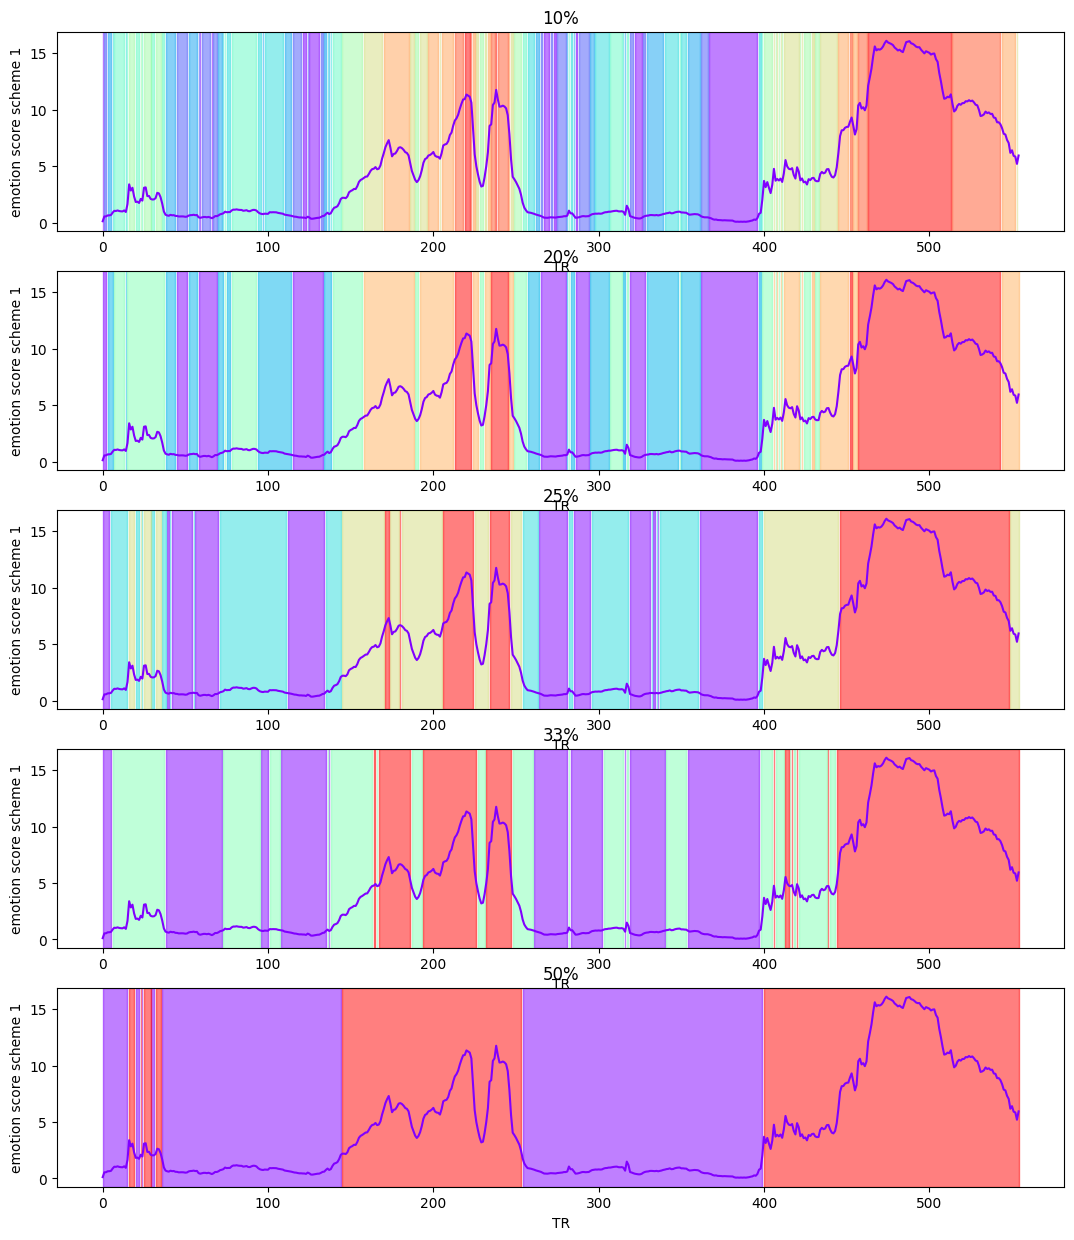

In [21]:
from matplotlib.pyplot import cm

iscores = intensity_scores[1]
mname = 'Sintel'

title = ["10%", "20%", "25%", "33%", "50%"]
all_bounds = [np.array(s10),np.array(s20), np.array(s25), np.array(s33), np.array(s50)]
fig, ax = plt.subplots(5,1,figsize=(13,15))
for idx,bounds in enumerate(all_bounds):
    color = cm.rainbow(np.linspace(0, 1, len(bounds)))
    for bdx,b in enumerate(bounds):
        lb,rb = b

        if bdx == 0:
            ax[idx].plot(iscores[mname], color=color[bdx])
                
        mask = compute_mask_percentile(iscores[mname], lb, rb)
        pairs = find_boundcontinuous(mask)
        for pair in pairs:
            ax[idx].axvspan(pair[0], pair[1], alpha=.5, color=color[bdx])

    ax[idx].set_xlabel('TR')
    ax[idx].set_ylabel('emotion score scheme 1')
    ax[idx].set_title(title[idx])

<a class="anchor" id="3fa"></a>
## Frame selected (by 3FA timecourses) series

In [10]:
filmnames = list(FILM2DURATION.keys())

In [11]:
import csv

fa_timecourse = {}
for fname in filmnames:
    with open("./data/emo3FA/3FA13_{}_stim.tsv".format(fname)) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        fa_timecourse[fname] = np.array(list(tsv_file), dtype=float)

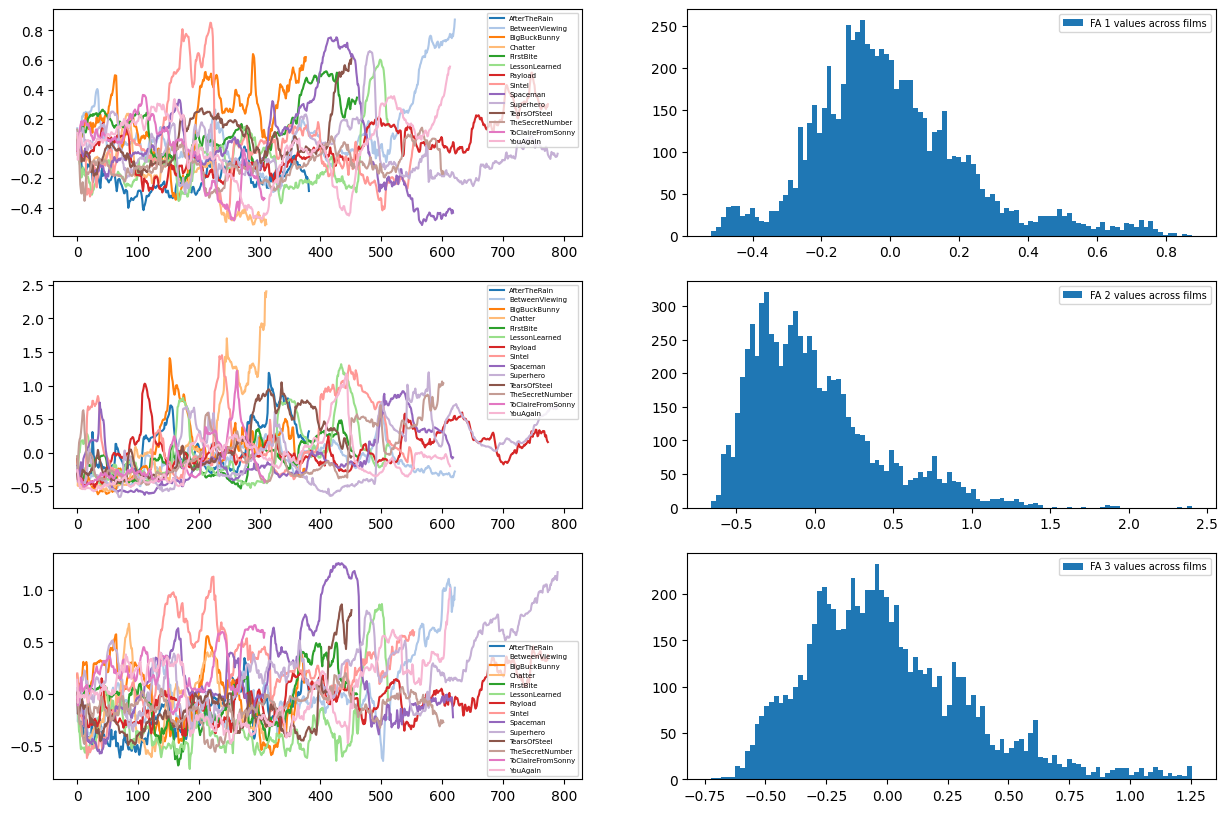

In [12]:
from matplotlib.colors import ListedColormap
# Displaying
pal     = sns.color_palette('tab20', len(fa_timecourse))
my_cmap = ListedColormap(pal)
fig, ax = plt.subplots(3,2,figsize=(15,10))

fa_thresh = {}
for k in range(3): # number of factors: 
    for idx,moviename in enumerate(fa_timecourse):
        ax[k,0].plot(fa_timecourse[moviename][:,k], label=moviename, color=my_cmap.colors[idx])
    ax[k,0].legend(prop={'size':5})

    distrib = np.concatenate(list(fa_timecourse.values()))[:,k]
    
    fa_thresh[k] = distrib
    ax[k,1].hist(distrib, bins=100, label='FA {} values across films'.format(k+1))
    ax[k,1].legend(prop={'size':7})

In [15]:
# In-Tervals percentages (non overlap)
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

thresholds = s5+s10+s20+s25+s33+s50

In [41]:
total_series = load('./data/fmri_414_series.pkl')

threshed_series = {}

# Frame select on emotions
for k in range(3): #for the 3 factors in FA
    # obtain threshed series for each "emotion intensity computation"
    per_score = {}
    
    for t in tqdm(range(len(thresholds))):
        # obtain threshed series for each "threshold"
        lb,rb = thresholds[t]
        per_threshold = {}
        
        for mname in total_series.keys():
            # obtain threshed series for each "movie"
            if mname == 'Rest': continue
            movie_series = total_series[mname]
            size = movie_series[next(iter(movie_series))].shape[0]
            mask = compute_mask_percentile(fa_timecourse[mname][:size,k], lb, rb) # take k-th factors
            
            per_movie = {}
            for _id in movie_series:
                # obtain threshed series for each "id"
                per_movie[_id] = movie_series[_id][mask]
            
            per_threshold[mname] = per_movie
        per_score[(lb,rb)] = per_threshold
    threshed_series[k] = per_score
    
save('./resources/fa_treshed_series.pkl', threshed_series)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [41]:
total_series = load('./data/fmri_414_series.pkl')

threshed_series = {}

# Frame select on emotions
for k in range(3): #for the 3 factors in FA
    # obtain threshed series for each "emotion intensity computation"
    per_score = {}
    
    thresholds_util = fa_thresh[k]
    for t in tqdm(range(len(thresholds))):
        # obtain threshed series for each "threshold"
        lb,rb = thresholds[t]
        lval, rval = np.percentile(thresholds_util, lb), np.percentile(thresholds_util, rb)
        per_threshold = {}
        
        for mname in total_series.keys():
            # obtain threshed series for each "movie"
            if mname == 'Rest': continue
            movie_series = total_series[mname]
            size = movie_series[next(iter(movie_series))].shape[0]
            mask =  (lval <= fa_timecourse[mname][:size,k]) & (fa_timecourse[mname][:size,k] <= rval)
#             mask = compute_mask_percentile(fa_timecourse[mname][:size,k], lb, rb) # take k-th factors
            per_movie = {}
            for _id in movie_series:
                # obtain threshed series for each "id"
                per_movie[_id] = movie_series[_id][mask]
            
            per_threshold[mname] = per_movie
        per_score[(lb,rb)] = per_threshold
    threshed_series[k] = per_score
    
save('./resources/fa_global_treshed_series.pkl', threshed_series)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

#### Visualizing the frame selected per percentiles (e.g scoring 2 in emotion timecourse) 
Also a quick snippet of the corresponding time series

In [8]:
total_series = load('./data/fmri_414_series.pkl')
del total_series['Rest']

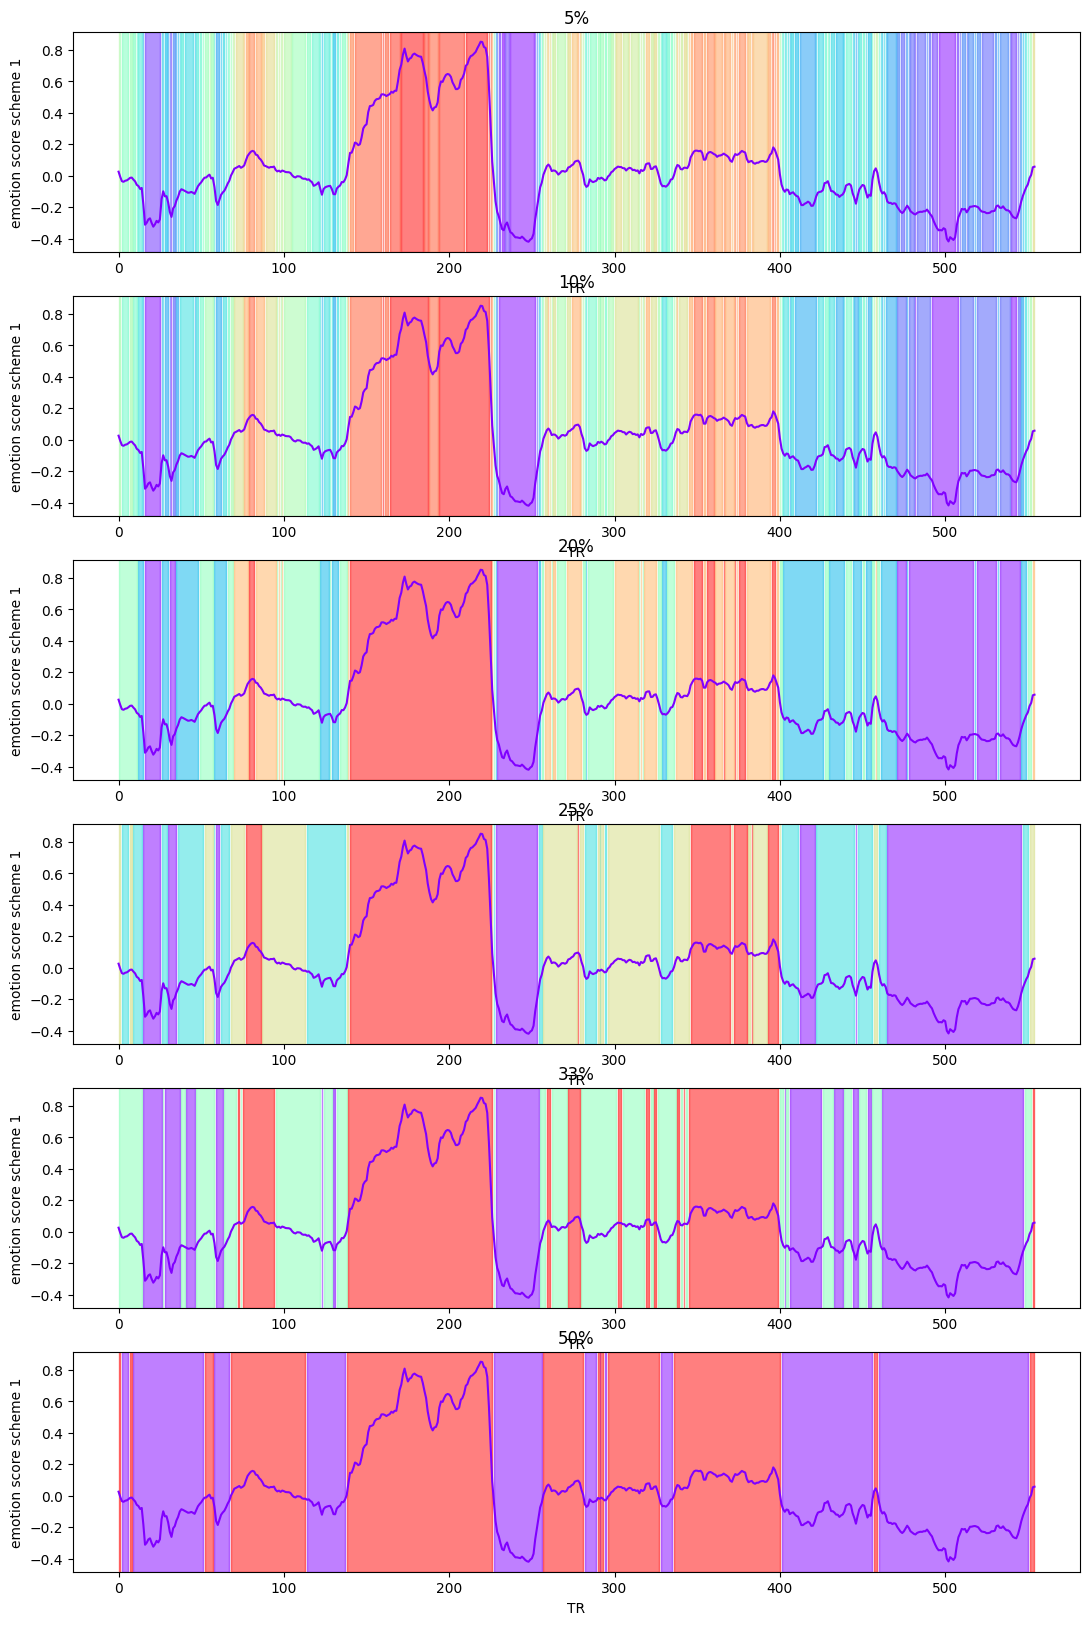

In [9]:
from matplotlib.pyplot import cm

fa_idx = 0
mname = 'Sintel'

title = ["5%","10%", "20%", "25%", "33%", "50%"]
all_bounds = [np.array(s5),np.array(s10),np.array(s20), np.array(s25), np.array(s33), np.array(s50)]

fig, ax = plt.subplots(len(title),1,figsize=(13,20))
for idx,bounds in enumerate(all_bounds):
    color = cm.rainbow(np.linspace(0, 1, len(bounds)))
    for bdx,b in enumerate(bounds):
        lb,rb = b
        if bdx == 0:
            ax[idx].plot(fa_timecourse[mname][:,fa_idx], color=color[bdx])
                
        mask = compute_mask_percentile(fa_timecourse[mname][:,fa_idx], lb, rb)
        pairs = find_boundcontinuous(mask)
        for pair in pairs:
#             if pair[1]-pair[0] < 0: continue
            ax[idx].axvspan(pair[0], pair[1], alpha=.5, color=color[bdx])
            
    ax[idx].set_xlabel('TR')
    ax[idx].set_ylabel('emotion score scheme 1')
    ax[idx].set_title(title[idx])

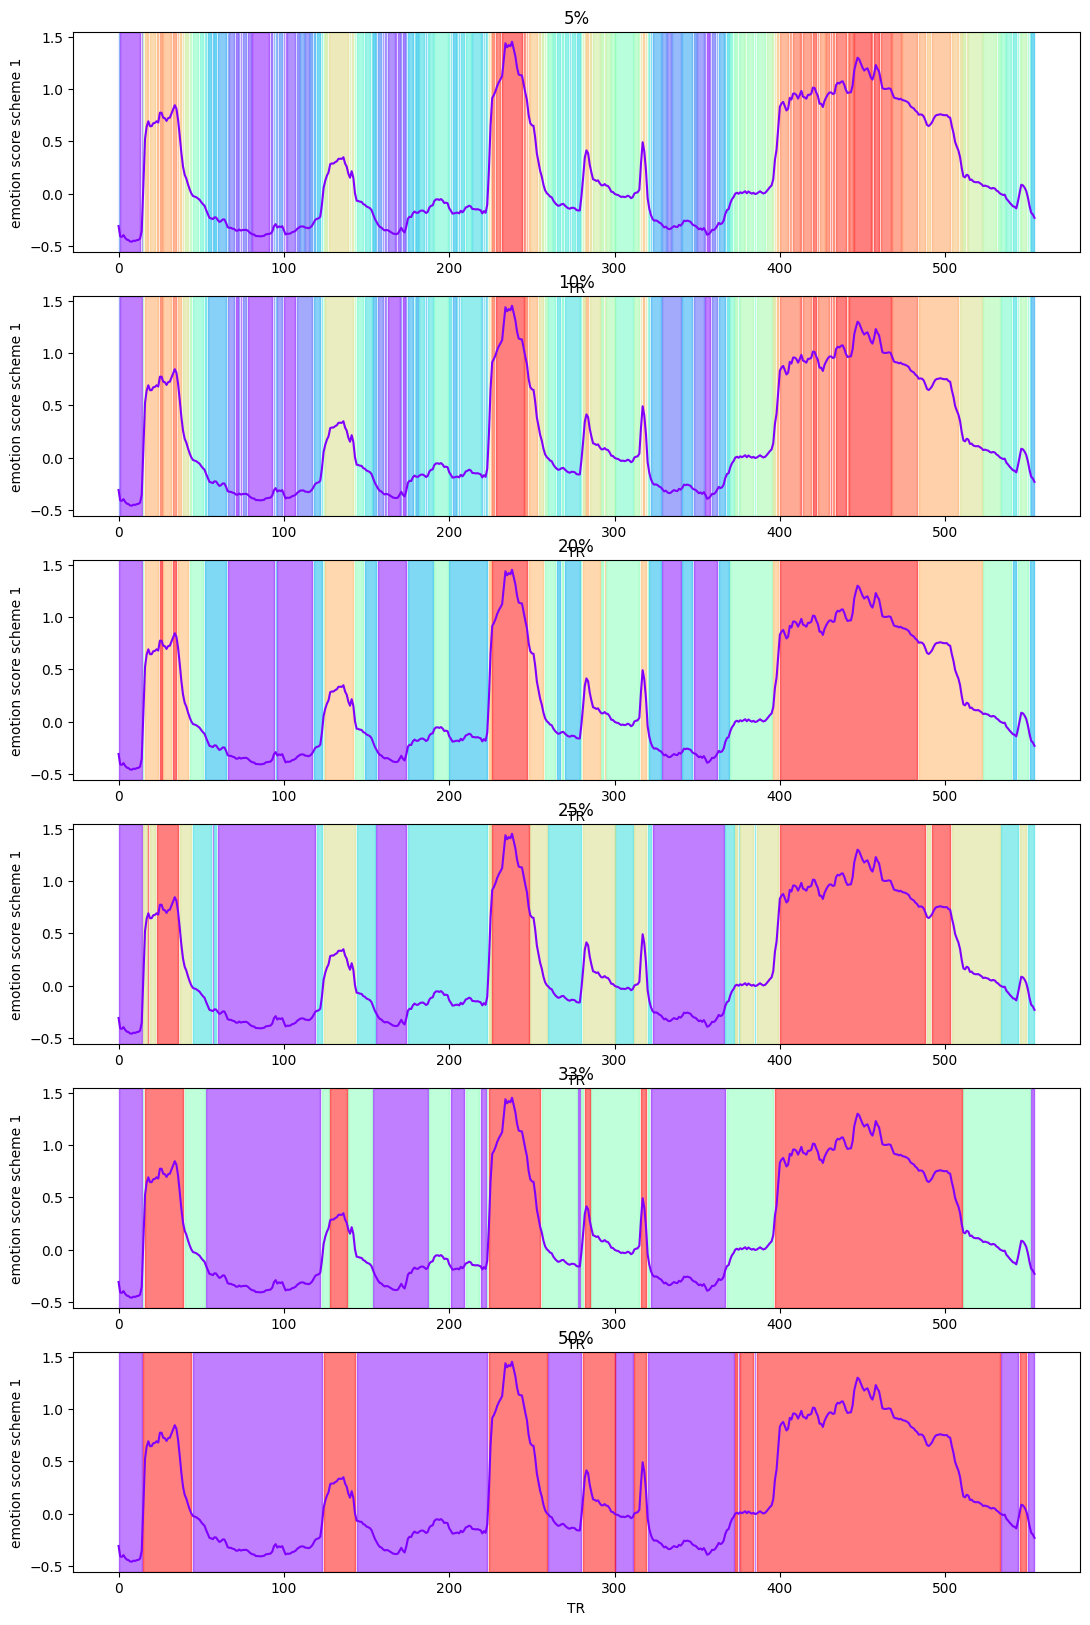

In [10]:
from matplotlib.pyplot import cm

fa_idx = 1
mname = 'Sintel'

title = ["5%","10%", "20%", "25%", "33%", "50%"]
all_bounds = [np.array(s5),np.array(s10),np.array(s20), np.array(s25), np.array(s33), np.array(s50)]

fig, ax = plt.subplots(len(title),1,figsize=(13,20))
for idx,bounds in enumerate(all_bounds):
    color = cm.rainbow(np.linspace(0, 1, len(bounds)))
    for bdx,b in enumerate(bounds):
        lb,rb = b
        if bdx == 0:
            ax[idx].plot(fa_timecourse[mname][:,fa_idx], color=color[bdx])
                
        mask = compute_mask_percentile(fa_timecourse[mname][:,fa_idx], lb, rb)
        pairs = find_boundcontinuous(mask)
        for pair in pairs:
#             if pair[1]-pair[0] < 0: continue
            ax[idx].axvspan(pair[0], pair[1], alpha=.5, color=color[bdx])
            
    ax[idx].set_xlabel('TR')
    ax[idx].set_ylabel('emotion score scheme 1')
    ax[idx].set_title(title[idx])

<a class="anchor" id="comb3fa"></a>
## Frame selected (by combination 3FA timecourses) series

In [5]:
filmnames = list(FILM2DURATION.keys())
import csv

fa_timecourse = {}
for fname in filmnames:
    with open("./data/emo3FA/3FA13_{}_stim.tsv".format(fname)) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        fa_timecourse[fname] = np.array(list(tsv_file), dtype=float)

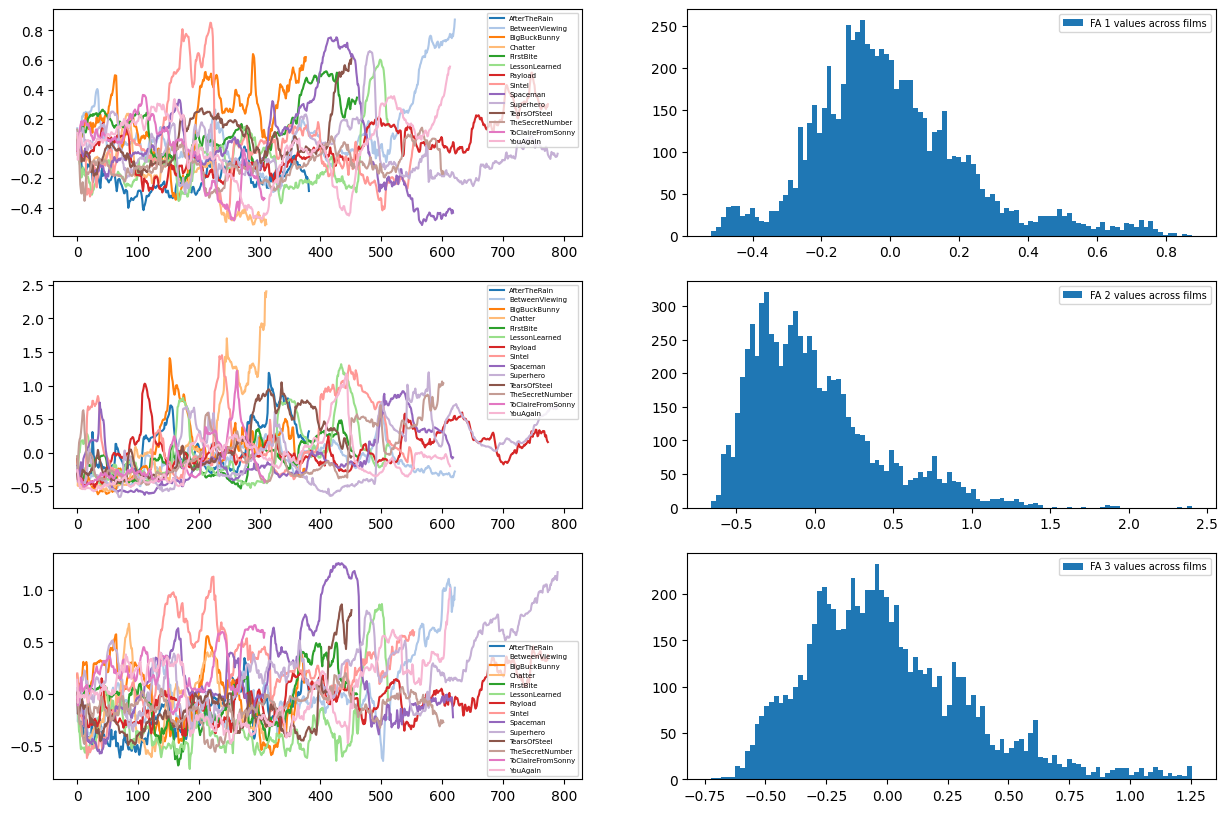

In [13]:
from matplotlib.colors import ListedColormap
# Displaying
pal     = sns.color_palette('tab20', len(fa_timecourse))
my_cmap = ListedColormap(pal)
fig, ax = plt.subplots(3,2,figsize=(15,10))

fa_thresh = {}
for k in range(3): # number of factors: 
    for idx,moviename in enumerate(fa_timecourse):
        ax[k,0].plot(fa_timecourse[moviename][:,k], label=moviename, color=my_cmap.colors[idx])
    ax[k,0].legend(prop={'size':5})

    distrib = np.concatenate(list(fa_timecourse.values()))[:,k]
    
    fa_thresh[k] = distrib
    ax[k,1].hist(distrib, bins=100, label='FA {} values across films'.format(k+1))
    ax[k,1].legend(prop={'size':7})

In [14]:
# In-Tervals percentages (non overlap)
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
thresholds = s20

In [15]:
total_series = load('./data/fmri_414_series.pkl')

threshed_series = {}

# Frame select on emotions
per_score = {}

thresholds_util1 = fa_thresh[0]
thresholds_util2 = fa_thresh[1]
for t1 in tqdm(range(len(thresholds))):
    # obtain threshed series for each "threshold"
    lb1,rb1 = thresholds[t1]
    for t2 in tqdm(range(len(thresholds))):
        lb2,rb2 = thresholds[t2]
        print((lb1,rb1), (lb2,rb2))
        print()
        lval1, rval1 = np.percentile(thresholds_util1, lb1), np.percentile(thresholds_util1, rb1)
        lval2, rval2 = np.percentile(thresholds_util2, lb2), np.percentile(thresholds_util2, rb2)    

        per_threshold = {}

        for mname in total_series.keys():
            # obtain threshed series for each "movie"
            if mname == 'Rest': continue
            movie_series = total_series[mname]
            size = movie_series[next(iter(movie_series))].shape[0]
            mask1 =  (lval1 <= fa_timecourse[mname][:size,0]) & (fa_timecourse[mname][:size,0] <= rval1)
            mask2 =  (lval2 <= fa_timecourse[mname][:size,1]) & (fa_timecourse[mname][:size,1] <= rval2)        

            mask = (mask1) & (mask2)
    #             mask = compute_mask_percentile(fa_timecourse[mname][:size,k], lb, rb) # take k-th factors
            per_movie = {}
            for _id in movie_series:
                # obtain threshed series for each "id"
                per_movie[_id] = movie_series[_id][mask]

            per_threshold[mname] = per_movie
        per_score[(lb1,rb1,lb2,rb2)] = per_threshold
    
save('./resources/threshed_series/fa_global_cross_tseries_val-aro_bin20.pkl', per_score)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(0, 10) (0, 10)

(0, 10) (10, 20)

(0, 10) (20, 30)

(0, 10) (30, 40)

(0, 10) (40, 50)

(0, 10) (50, 60)

(0, 10) (60, 70)

(0, 10) (70, 80)

(0, 10) (80, 90)

(0, 10) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(10, 20) (0, 10)

(10, 20) (10, 20)

(10, 20) (20, 30)

(10, 20) (30, 40)

(10, 20) (40, 50)

(10, 20) (50, 60)

(10, 20) (60, 70)

(10, 20) (70, 80)

(10, 20) (80, 90)

(10, 20) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(20, 30) (0, 10)

(20, 30) (10, 20)

(20, 30) (20, 30)

(20, 30) (30, 40)

(20, 30) (40, 50)

(20, 30) (50, 60)

(20, 30) (60, 70)

(20, 30) (70, 80)

(20, 30) (80, 90)

(20, 30) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(30, 40) (0, 10)

(30, 40) (10, 20)

(30, 40) (20, 30)

(30, 40) (30, 40)

(30, 40) (40, 50)

(30, 40) (50, 60)

(30, 40) (60, 70)

(30, 40) (70, 80)

(30, 40) (80, 90)

(30, 40) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(40, 50) (0, 10)

(40, 50) (10, 20)

(40, 50) (20, 30)

(40, 50) (30, 40)

(40, 50) (40, 50)

(40, 50) (50, 60)

(40, 50) (60, 70)

(40, 50) (70, 80)

(40, 50) (80, 90)

(40, 50) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(50, 60) (0, 10)

(50, 60) (10, 20)

(50, 60) (20, 30)

(50, 60) (30, 40)

(50, 60) (40, 50)

(50, 60) (50, 60)

(50, 60) (60, 70)

(50, 60) (70, 80)

(50, 60) (80, 90)

(50, 60) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(60, 70) (0, 10)

(60, 70) (10, 20)

(60, 70) (20, 30)

(60, 70) (30, 40)

(60, 70) (40, 50)

(60, 70) (50, 60)

(60, 70) (60, 70)

(60, 70) (70, 80)

(60, 70) (80, 90)

(60, 70) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(70, 80) (0, 10)

(70, 80) (10, 20)

(70, 80) (20, 30)

(70, 80) (30, 40)

(70, 80) (40, 50)

(70, 80) (50, 60)

(70, 80) (60, 70)

(70, 80) (70, 80)

(70, 80) (80, 90)

(70, 80) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(80, 90) (0, 10)

(80, 90) (10, 20)

(80, 90) (20, 30)

(80, 90) (30, 40)

(80, 90) (40, 50)

(80, 90) (50, 60)

(80, 90) (60, 70)

(80, 90) (70, 80)

(80, 90) (80, 90)

(80, 90) (90, 100)



  0%|          | 0/10 [00:00<?, ?it/s]

(90, 100) (0, 10)

(90, 100) (10, 20)

(90, 100) (20, 30)

(90, 100) (30, 40)

(90, 100) (40, 50)

(90, 100) (50, 60)

(90, 100) (60, 70)

(90, 100) (70, 80)

(90, 100) (80, 90)

(90, 100) (90, 100)



<a class="anchor" id="pareto3fa"></a>
## Frame selected (by pareto 3FA timecourses) series

In [4]:
filmnames = list(FILM2DURATION.keys())

In [5]:
import csv

fa_timecourse = {}
for fname in filmnames:
    with open("./data/emo3FA/3FA13_{}_stim.tsv".format(fname)) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        fa_timecourse[fname] = np.array(list(tsv_file), dtype=float)

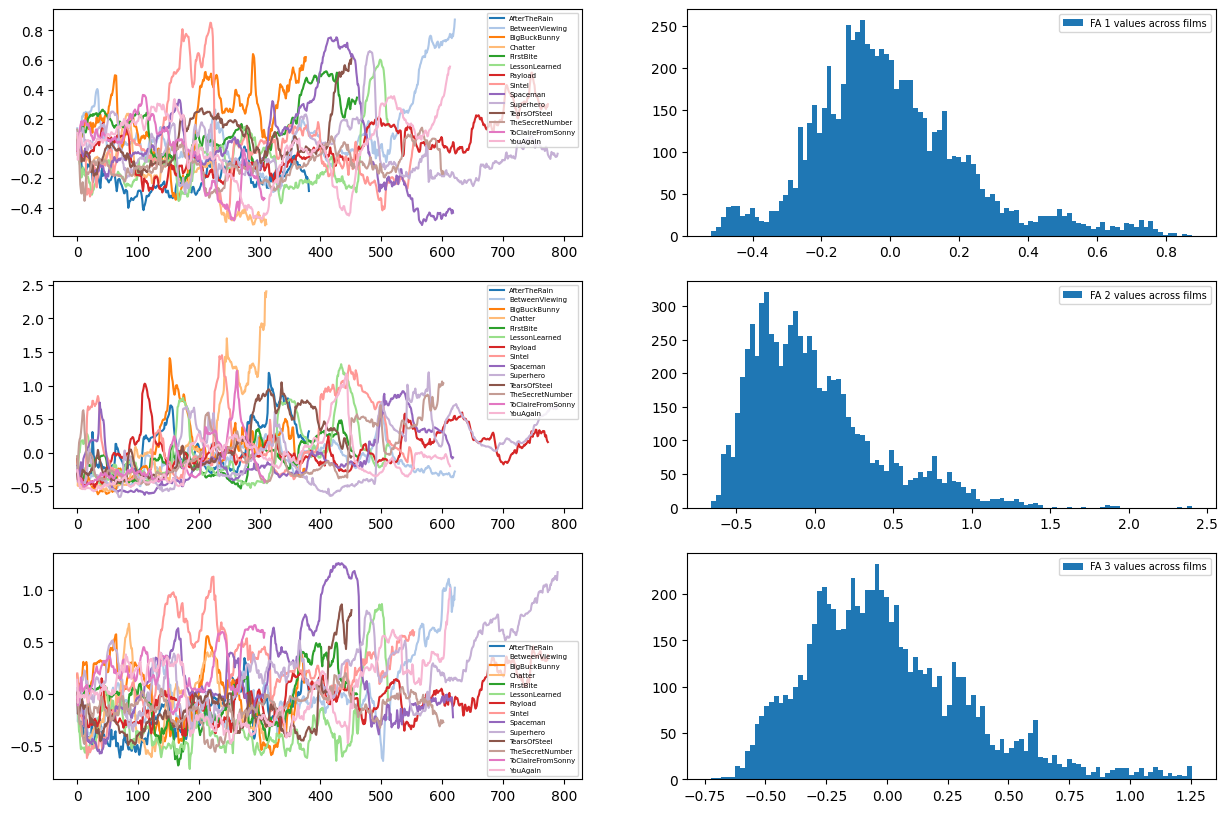

In [6]:
from matplotlib.colors import ListedColormap
# Displaying
pal     = sns.color_palette('tab20', len(fa_timecourse))
my_cmap = ListedColormap(pal)
fig, ax = plt.subplots(3,2,figsize=(15,10))

for k in range(3): # number of factors: 
    for idx,moviename in enumerate(fa_timecourse):
        ax[k,0].plot(fa_timecourse[moviename][:,k], label=moviename, color=my_cmap.colors[idx])
    ax[k,0].legend(prop={'size':5})

    distrib = np.concatenate(list(fa_timecourse.values()))[:,k]
    ax[k,1].hist(distrib, bins=100, label='FA {} values across films'.format(k+1))
    ax[k,1].legend(prop={'size':7})

In [40]:
# In-Tervals percentages (non overlap)
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

# define the thresholds using ranges (lb,rb)
thresholds = s5 + s10 + s20 + s25 + s33 + s50

In [41]:
total_series = load('./data/fmri_414_series.pkl')

threshed_series = {}

# Frame select on emotions
for k in range(3): #for the 3 factors in FA
    # obtain threshed series for each "emotion intensity computation"
    per_score = {}
    
    thresholds_util = fa_thresh[k]
    for t in tqdm(range(len(thresholds))):
        # obtain threshed series for each "threshold"
        lb,rb = thresholds[t]
        lval, rval = np.percentile(thresholds_util, lb), np.percentile(thresholds_util, rb)
        per_threshold = {}
        
        for mname in total_series.keys():
            # obtain threshed series for each "movie"
            if mname == 'Rest': continue
            movie_series = total_series[mname]
            size = movie_series[next(iter(movie_series))].shape[0]
            mask =  (lval <= fa_timecourse[mname][:size,k]) & (fa_timecourse[mname][:size,k] <= rval)
#             mask = compute_mask_percentile(fa_timecourse[mname][:size,k], lb, rb) # take k-th factors
            per_movie = {}
            for _id in movie_series:
                # obtain threshed series for each "id"
                per_movie[_id] = movie_series[_id][mask]
            
            per_threshold[mname] = per_movie
        per_score[(lb,rb)] = per_threshold
    threshed_series[k] = per_score
    
save('./resources/fa_global_treshed_series.pkl', threshed_series)

  0%|          | 0/44 [00:00<?, ?it/s]

#### Visualizing the frame selected per percentiles (e.g scoring 2 in emotion timecourse) 
Also a quick snippet of the corresponding time series

In [42]:
total_series = load('./data/fmri_414_series.pkl')
del total_series['Rest']

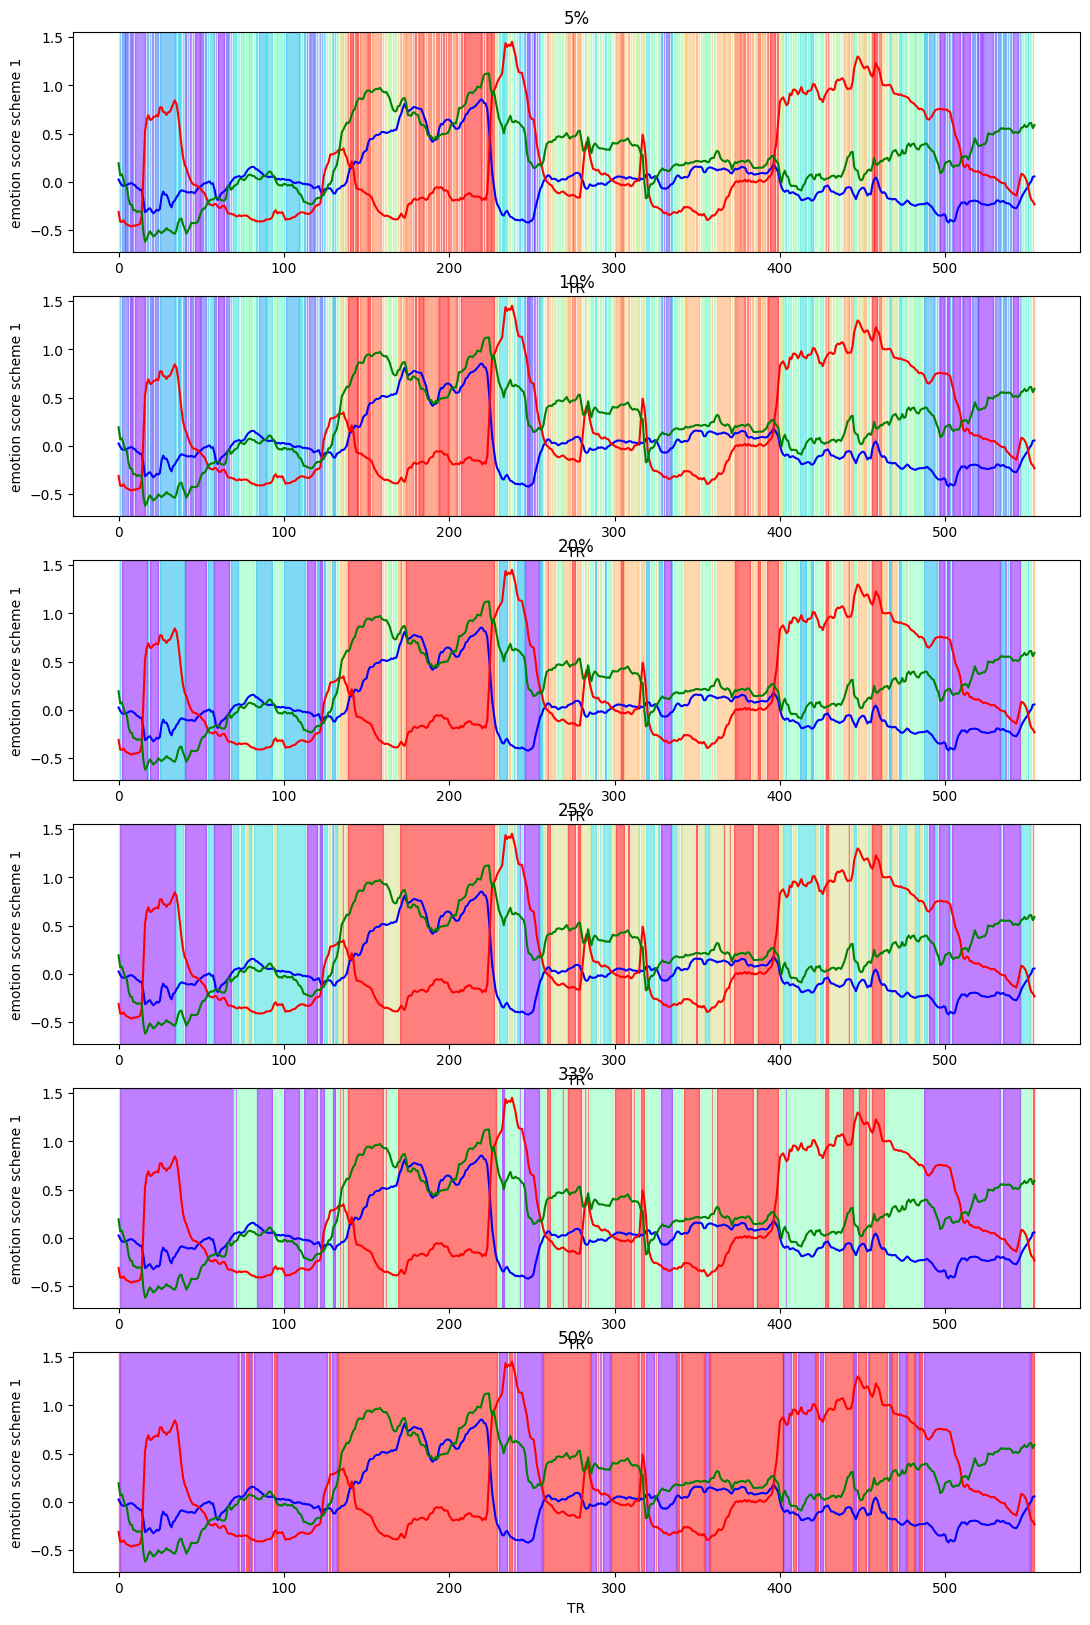

In [47]:
from matplotlib.pyplot import cm

mname = 'Sintel'

title = ["5%","10%", "20%", "25%", "33%", "50%"]
all_bounds = [np.array(s5),np.array(s10),np.array(s20), np.array(s25), np.array(s33), np.array(s50)]

fig, ax = plt.subplots(len(title),1,figsize=(13,20))
for idx,bounds in enumerate(all_bounds):
    color = cm.rainbow(np.linspace(0, 1, len(bounds)))
    for bdx,b in enumerate(bounds):
        lb,rb = b
        if bdx == 0:
            ax[idx].plot(fa_timecourse[mname][:,0], color='b')
            ax[idx].plot(fa_timecourse[mname][:,1], color='r')
            ax[idx].plot(fa_timecourse[mname][:,2], color='g')            

        _,_,_,ndr = pg.fast_non_dominated_sorting(fa_timecourse[mname])
        indexes = np.argsort(ndr)[len(ndr)*lb//100:len(ndr)*rb//100+1]
        mask = np.zeros(len(ndr))
        mask[indexes] = True
        
        pairs = find_boundcontinuous(mask)
        for pair in pairs:
#             if pair[1]-pair[0] < 0: continue
            ax[idx].axvspan(pair[0], pair[1], alpha=.5, color=color[bdx])
            
    ax[idx].set_xlabel('TR')
    ax[idx].set_ylabel('emotion score scheme 1')
    ax[idx].set_title(title[idx])